In [11]:
from IPython.display import HTML, Image
HTML('''
<script
    src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js ">
</script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
''')

In [1]:
import os
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import pandas as pd
import numpy as np 

import warnings
warnings.filterwarnings('ignore')

In [2]:
spark = (SparkSession
         .builder
         .master('local[*]')
         .config('spark.sql.execution.arrow.pyspark.enabled', 'true')
         .getOrCreate())
spark.sparkContext.setLogLevel('OFF')

In [4]:
cal_sdf = spark.read.csv('/mnt/data/public/insideairbnb/data.insideairbnb.com'
                         '/*/*/*/202{1,2,3}*/data/calendar.csv.gz',
                         header=True)

In [5]:
list_sdf = spark.read.csv('/mnt/data/public/insideairbnb/data.insideairbnb.com'
                          '/*/*/*/202{1,2,3}*/data/listings.csv.gz',
                          header=True)

In [3]:
list_parq = spark.read.parquet('bdcc_lab/partitioned_listings_parquet')

In [4]:
from pyspark.sql.types import IntegerType

listing_roomtype = (
    list_parq
    .select('id','room_type')
    .withColumn("id", F.regexp_replace(F.col("id"), "[^0-9]", ""))
    .filter(F.col("id").cast(IntegerType()).isNotNull())
    .filter(F.col('room_type').rlike('(?i)^(Entire|Private|Shared)'))
    .withColumn("room_type",
                F.when(F.col("room_type").rlike('(?i)^Entire'), "Entire Place")
                .when(F.col("room_type").rlike('(?i)^Private'), "Private Room")
                .when(F.col("room_type").rlike('(?i)^Shared'), "Shared Room")
                .otherwise(F.col("room_type")))
    .distinct()
)

In [5]:
cal_parq = spark.read.parquet('bdcc_lab/partitioned_calendar_parquet')

In [6]:
cal_df = cal_parq.filter(F.col('year_month')<= '2023-12')
list_df = listing_roomtype
combined_df = cal_df.join(list_df,
                          cal_df.listing_id==list_df.id,
                          how='inner')

In [7]:
from pyspark.sql.types import DoubleType

exchange_rates_to_usd = {
    # North America
    "canada": 0.73,
    "mexico": 0.060,
    "united-states": 1,
    "belize": 0.50,

    # South America
    "argentina": 0.0011,
    "brazil": 0.19,
    "chile": 0.0011,

    # Europe
    "belgium": 1.08,
    "czech-republic": 0.043,
    "germany": 1.08,
    "italy": 1.08,
    "norway": 0.092,
    "sweden": 0.092,
    "united-kingdom": 1.25,
    "denmark": 0.14,
    "greece": 1.08,
    "portugal": 1.08,
    "switzerland": 1.10,
    "the-netherlands": 1.08,
    "austria": 1.08,
    "france": 1.08,
    "latvia": 1.08,
    "spain": 1.08,
    "turkey": 0.031,

    # Asia
    "singapore": 0.74,
    "thailand": 0.027,
    "japan": 0.0064,
    "china": 0.14,
    "taiwan": 0.031,
    

    # Africa
    "south-africa": 0.054,

    # Oceania
    "australia": 0.66
}


# Define a UDF to convert currency based on the country
def convert_to_usd(country, price):
    """Convert a country's local currency into USD"""
    rate = exchange_rates_to_usd.get(country, 1)  # Default to 1 if the country is not found
    return price * rate

# Register UDF
convert_to_usd_udf = F.udf(convert_to_usd, DoubleType())

In [52]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_city_trends(city, listing_counts_df, availability_df):
    """
    Plot side by side the distribution of `room_types` and availability trend
    of a city
    """
    # Create the subplot figure object with 1 row and 2 columns
    fig = make_subplots(rows=1,
                        cols=2,
                        subplot_titles=('Room Type Distribution by City',
                                        'Availability Ratio Trend by Year/'
                                        'Month'))
    
    # Filter data for the selected city
    df_listing_counts = listing_counts_df[listing_counts_df['city'] == city]
    df_availability = availability_df[availability_df['city'] == city]
    
    # Adding traces for room type distribution
    room_types = df_listing_counts['room_type'].unique()
    color_map = {
        'Entire Place': 'rgb(90, 70, 144)',
        'Private Room': 'rgb(29, 105, 150)',
        'Shared Room': 'rgb(56, 166, 165)'
    }
    
    legend_added = set()
    max_unique_listings = df_listing_counts['unique_listings'].sum()
    
    for room_type in room_types:
        filtered_room_df = (df_listing_counts[
                            df_listing_counts['room_type'] == room_type])
        fig.add_trace(go.Bar(
            x=filtered_room_df['city'],
            y=filtered_room_df['unique_listings'],
            name=room_type,
            text=filtered_room_df['unique_listings'],
            textposition='auto',
            marker_color=color_map[room_type],  # Set color based on room type
            showlegend=room_type not in legend_added  # Show legend only if not already added
        ))
        legend_added.add(room_type)  # Mark this room type as added to the legend
    
    # Adding padding to y-axis for room type distribution
    yaxis_room_type_range = [0, max_unique_listings * 1.2]
    
    # Change the bar mode to stack
    fig.update_layout(
        barmode='stack',
        xaxis_title='City',
        yaxis_title='Number of Unique Listings',
        legend_title='Room Type',
        yaxis=dict(range=yaxis_room_type_range)
    )
    
    # Adding traces for availability ratio trends
    fig.add_trace(go.Scatter(
        x=df_availability['year_month'],
        y=df_availability['availability_ratio'],
        mode='lines+markers',
        name='Availability Ratio'
    ), row=1, col=2)
    
    # Update layout for titles and axis labels
    fig.update_layout(
        title_text=f'Trends for {city.title()} by Year/Month',
        xaxis1_title='City',
        yaxis1_title='Number of Unique Listings',
        xaxis2_title='Year/Month',
        yaxis2_title='Availability Ratio',
        yaxis2=dict(range=[0, 0.7])
    )
    
    # Show figure
    fig.show()

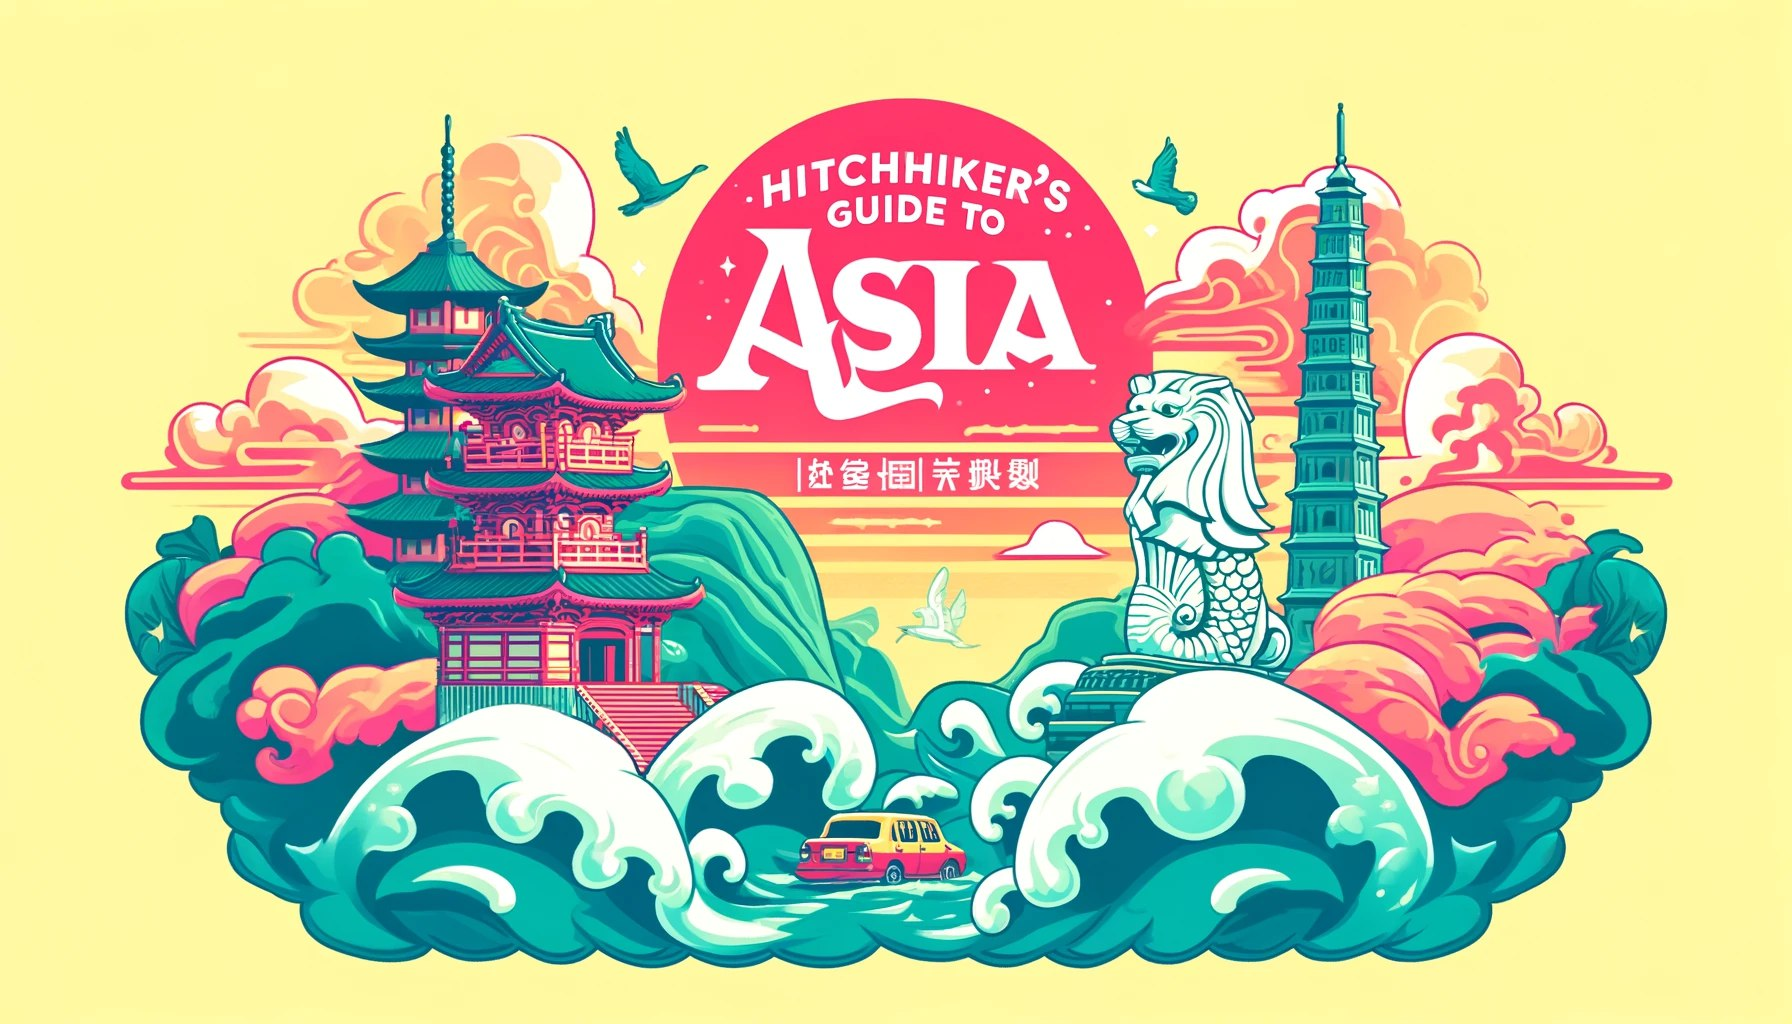

In [44]:
banner = 'banner.jpg'

Image(filename=banner)

<a name="title"></a>
<h1 style=" color: #045a63">Hitch Hiker's Guide to Asia </h1>

***


<a name="top"></a>
#### Table of Contents:

[ref0]: #abstract
- [Abstract][ref0]

[ref1]: #prob_stat
- [Problem Statement][ref1]

[ref3]: #motiv
- [Motivation][ref3]

[ref4]: #dat_sor
- [Data Source][ref4]

[ref5]: #met
- [Methodology][ref5]

[ref6]: #dat_prep
- [Data Preprocessing][ref6]

[ref7]: #dat_expl
- [Data Exploration][ref7]

[ref9]: #conc
- [Conclusion and Insights][ref9]

[ref10]: #reco
- [Recommendations][ref10]

[ref11]: #refe
- [References][ref11]

***

<a name="abstract"></a>
<h2 style=" color: #045a63">Abstract</h2>

***

This study delves into how Big Data wrangling and analysis can empower the Asian tourism industry. By leveraging Airbnb's online rental platform data, the research explores post-pandemic trends (2021 onwards) in both property availability and pricing. PySpark and its accompanying Python libraries are utilized to tackle the Big Data processing and exploration tasks.  

The researchers compared the the region's performance to other continents, showing that there much room to improve. Zooming in on Asia, the study identified peak seasons and recommend alternative travel times for a less crowded experience. Price stability enabled affordability rankings of Asian cities, while room type distribution provided insights into dominant traveler demographics. These findings evolved into The Hitchhiker's Guide to Asia, offering personalized recommendations based off Big Data insight. 

Big Data processing presented challenges, as will be shown in this notebook. Nonetheless, this works depicts process how these setback were tackled, as well as provided recommendations on how to avoid them in future iterations.

[ref]: #top
[Back to Table of Contents][ref]

<a name="prob_stat"></a>
<h2 style=" color: #045a63">Problem Statement</h2>

***
Traditional tourism guides and blog posts, while informative, often rely on subjective experiences and limited data.  This project proposes a revolutionary approach: a "Hitchhiker's Guide to Asia" leveraging the power of Big Data from Airbnb rentals.

This guide won't be constrained by subjective opinions or anecdotal experiences.  By analyzing vast datasets of Airbnb rentals, the project will uncover hidden patterns and trends invisible to traditional methods.  This includes insights into current travel patterns, the availability and pricing of accommodation across popular Asian destinations.

The Big Data approach unlocks access to actionable information. This empowers travelers with insights on both monthly pricing and rental availability across Asia, enabling informed decisions and budget-friendly exploration while supporting Asian tourism year-round.
  
[ref]: #top
[Back to Table of Contents][ref]

<a name="motiv"></a>
<h2 style=" color: #045a63">Movivation</h2>

***
Prior to the pandemic, travel and tourism were a cornerstone of the global economy, accounting for a staggering 10% of global GDP and employing over 320 million people worldwide (IMF, 2020).  In Asia, this sector played an even more critical role, with several economies heavily reliant on tourism revenue.  

However, the COVID-19 pandemic has delivered a crippling blow.  With travel restrictions and border closures, Asia has witnessed devastating economic consequences.  Furthermore, "Asia-phobia," an unfounded fear linked to the pandemic's origins, discourages potential visitors and hinders recovery.

Asia's tourism recovery has been significantly slower compared to other regions. While Europe, Africa, and the Americas have rebounded to over 90% of pre-pandemic tourist levels, Asia has only reached 65% (UNWTO, 2022). This disparity is projected to continue, with Asia's full recovery lagging a full year behind the global average, with a projected return to pre-pandemic levels by 2025 (UNWTO, 2022).

Addressing this uneven recovery is crucial. Innovative solutions are needed to revitalize tourism-dependent economies in Asia. This project aims to empower travelers with actionable insights and fostering a more adventurous travel style, which can play a significant role in Asia's tourism revival.

[ref]: #top
[Back to Table of Contents][ref]

<a name="dat_sor"></a>
<h2 style=" color: #045a63">Data Source</h2>

***

[ref]: #top
[Back to Table of Contents][ref]


<h3 style=" color: #0">Inside Airbnb</h3>

This project leverages open-source data from <a href="https://insideairbnb.com/get-the-data/">Inside Airbnb</a>. The dataset 
is a compilation of listings across various cities around the world. By analyzing this extensive dataset, we can gain valuable insights into current travel patterns, accommodation options, and pricing trends in popular Asian destinations. 

Specifically for this use case, a downloaded version of the dataset stored on AIM's public data directory will be utilized. Given its size, PySpark will be employed to access information inside the dataset. The exact filepath and a preview of the data is shown below.

It is worth noting that Inside Airbnb scrapes data 365 days into the future. Meaning, a scrape date of 12/31/2023 would contain information over the entirety of 2024. For the sake of clarity, the succeeding parts already reflect necessary adjustements to be able interpret information at face value. 


In [11]:
print('Table 1. Sample rows for `calendar.csv.gz` files')

Table 1. Sample rows for `calendar.csv.gz` files


In [12]:
cal_sdf.show(5)

+----------+----------+---------+-----+--------------+--------------+--------------+
|listing_id|      date|available|price|adjusted_price|minimum_nights|maximum_nights|
+----------+----------+---------+-----+--------------+--------------+--------------+
|     13913|2023-12-10|        f| NULL|          NULL|             1|            29|
|     13913|2023-12-11|        t| NULL|          NULL|             1|            29|
|     13913|2023-12-12|        t| NULL|          NULL|             1|            29|
|     13913|2023-12-13|        t| NULL|          NULL|             1|            29|
|     13913|2023-12-14|        t| NULL|          NULL|             1|            29|
+----------+----------+---------+-----+--------------+--------------+--------------+
only showing top 5 rows



In [13]:
print('Table 2. Sample row for `listings.csv.gz` files')

Table 2. Sample row for `listings.csv.gz` files


In [14]:
list_sdf.show(1, vertical=True, truncate=50)

-RECORD 0------------------------------------------------------------------------------------------
 id                                           | 11551                                              
 listing_url                                  | https://www.airbnb.com/rooms/11551                 
 scrape_id                                    | 20210111152602                                     
 last_scraped                                 | 2021-01-13                                         
 name                                         | Arty and Bright London Apartment in Zone 2         
 description                                  | Unlike most rental apartments out there my flat... 
 neighborhood_overview                        | Not even 10 minutes by metro from Victoria Stat... 
 picture_url                                  | https://a0.muscache.com/pictures/b7afccf4-18e5-... 
 host_id                                      | 43039                                              


In [ ]:
# Proof of 16 GB
# !du -sch /mnt/data/public/insideairbnb/data.insideairbnb.com/*/*/*/202{1,2,3}*/data/{calendar,listings}.csv.gz

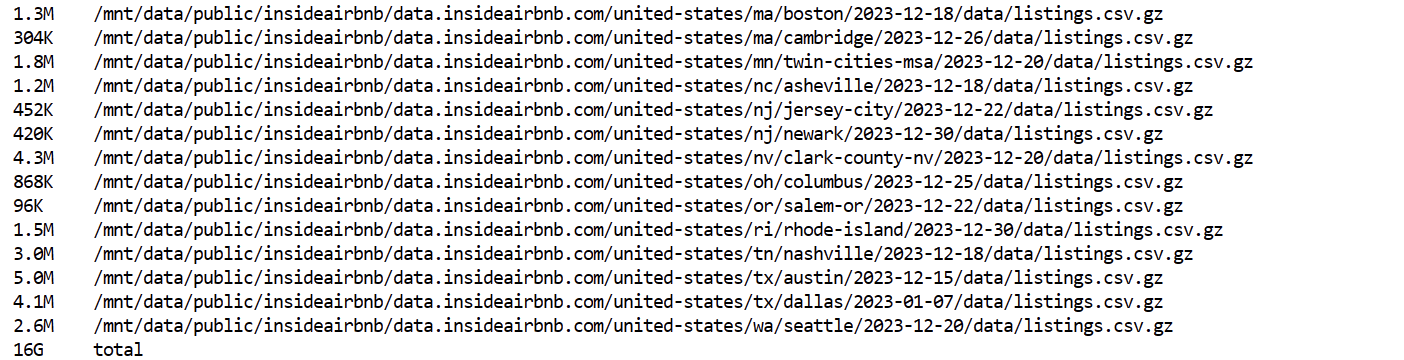

In [47]:
image_path_gigs = '16Gigs.png'

Image(filename=image_path_gigs)

In [15]:
print('Figure 1. Total file size of `calendar` and `listings` csv files')

Figure 1. Total file size of `calendar` and `listings` csv files


<a name="met"></a>
<h2 style=" color: #045a63">Methodology</h2>

***

[ref]: #top
[Back to Table of Contents][ref]



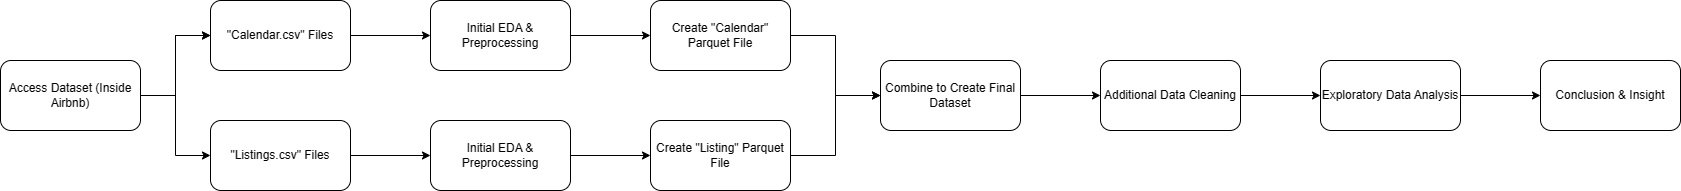

In [46]:
image_path = 'lab.drawio.png'

Image(filename=image_path)

In [35]:
print('Figure 2. Methodology pipeline')

Figure 2. Methodology pipeline


<a name="dat_prep"></a>
<h2 style=" color: #045a63">Data Preprocessing</h2>

***

[ref]: #top
[Back to Table of Contents][ref]

Prior to analyzing Asian travel trends, a crucial step is preprocessing the Airbnb data. This step allows efficient and accurate analysis of data, providing reliable insights and results.


<h4 style=" color: #045a63">Initial Exploration</h4>
Initial exploration allows us to preview the data within the directory to check for potential inconsistencies, missing values, and outliers. This is a crucial precaution before creating parquet files.
    

From the initial dataset we narrow it down the following features:
- From Calendar files - listing_id, date, available, price, 
- From Listing files - id, room_type

In [16]:
print('Table 3. Sample rows of selected `calendar` features')

Table 3. Sample rows of selected `calendar` features


In [17]:
cal_sdf.select('listing_id','date','available','price').show(5)

+----------+----------+---------+-----+
|listing_id|      date|available|price|
+----------+----------+---------+-----+
|     13913|2023-12-10|        f| NULL|
|     13913|2023-12-11|        t| NULL|
|     13913|2023-12-12|        t| NULL|
|     13913|2023-12-13|        t| NULL|
|     13913|2023-12-14|        t| NULL|
+----------+----------+---------+-----+
only showing top 5 rows



In [18]:
print('Table 4. Sample rows of selected `listings` features')

Table 4. Sample rows of selected `listings` features


In [19]:
list_sdf.select('id','room_type').show(5)

+--------------------+---------+
|                  id|room_type|
+--------------------+---------+
|               11551|     NULL|
|I am endlessly cu...|     NULL|
|      I love Science|     NULL|
|I always keep my ...|     NULL|
|Currently doing a...|     NULL|
+--------------------+---------+
only showing top 5 rows



For both files, we also extract filepath as these contain information to be used on the following:
- Country 
- City 
- Crawl dates 

In [20]:
print('Table 5. Sample rows of selected `calendar` features with `file_path`')

Table 5. Sample rows of selected `calendar` features with `file_path`


In [21]:
(
    cal_sdf.withColumn('file_path', F.input_file_name())
    .select('listing_id','date','available','price','file_path')
).show(3, vertical=True, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------
 listing_id | 13913                                                                                                                    
 date       | 2023-12-10                                                                                                               
 available  | f                                                                                                                        
 price      | NULL                                                                                                                     
 file_path  | file:///mnt/data/public/insideairbnb/data.insideairbnb.com/united-kingdom/england/london/2023-12-10/data/calendar.csv.gz 
-RECORD 1------------------------------------------------------------------------------------------------------------------------------
 listing_id | 13913                             

In [22]:
print('Table 6. Sample rows of selected `listings` features with `file_path`')

Table 6. Sample rows of selected `listings` features with `file_path`


In [23]:
(
    list_sdf.withColumn('file_path', F.input_file_name())
    .select('id','room_type', 'file_path')
).show(3, vertical=True, truncate=False)

-RECORD 0-----------------------------------------------------------------------------------------------------------------------------
 id        | 11551                                                                                                                    
 room_type | NULL                                                                                                                     
 file_path | file:///mnt/data/public/insideairbnb/data.insideairbnb.com/united-kingdom/england/london/2021-01-11/data/listings.csv.gz 
-RECORD 1-----------------------------------------------------------------------------------------------------------------------------
 id        | I am endlessly curious. I love to experience the world with eyes wide open. I never stop exploring                       
 room_type | NULL                                                                                                                     
 file_path | file:///mnt/data/public/insideairbnb/data.

In total, we are working with 3,873,073,400 rows of calendar information and 21,061,973 rows of listing information.

In [24]:
print("The total number of rows from all the `calendar.csv.gz` files:")

The total number of rows from all the `calendar.csv.gz` files:


In [80]:
cal_sdf.count()

3873073400

In [25]:
print("The total number of rows from all the `listings.csv.gz` files:")

The total number of rows from all the `listings.csv.gz` files:


In [79]:
list_sdf.count()

21061973

<h4 style=" color: #045a63">Creating Parquet Files</h4>
Parquet files allow us to store information in columnar formats. Reading the entire dataset through Spark each time cost significant computation power and time. Using parquets breaks down said process into manageable tasks by allowing us to nest information.

Given the size of the Calendar files, we opted create a loop that breaks down the proccesses into individual continents, countries, and years to work within the memory limits. 

Note: The codes below are not executable as to not start another parquet creation process.

The dictionary below maps countries to their respective continents. It is used later to add a continent column to the DataFrame.

##### *Table 7. Continent Mapping Dictionary*

| Country                  | Continent        |
|--------------------------|------------------|
| South Africa             | Africa           |
|--------------------------|------------------|
| Singapore                | Asia             |
| Thailand                 | Asia             |
| Japan                    | Asia             |
| China                    | Asia             |
| Taiwan                   | Asia             |
|--------------------------|------------------|
| Australia                | Australia        |
| New Zealand              | Australia        |
|--------------------------|------------------|
| Belgium                  | Europe           |
| Czech Republic           | Europe           |
| Germany                  | Europe           |
| Italy                    | Europe           |
| Malta                    | Europe           |
| Norway                   | Europe           |
| Sweden                   | Europe           |
| United Kingdom           | Europe           |
| Denmark                  | Europe           |
| Greece                   | Europe           |
| Portugal                 | Europe           |
| Switzerland              | Europe           |
| The Netherlands          | Europe           |
| Austria                  | Europe           |
| France                   | Europe           |
| Ireland                  | Europe           |
| Latvia                   | Europe           |
| Spain                    | Europe           |
| Turkey                   | Europe           |
|--------------------------|------------------|
| Canada                   | North America    |
| Belize                   | North America    |
| Mexico                   | North America    |
| United States            | North America    |
|--------------------------|------------------|
| Argentina                | South America    |
| Brazil                   | South America    |
| Chile                    | South America    |







This pattern extracts parts of the file path for country, region, city, and crawl date.

*Listing 1.1 Regex pattern to capture `country`, `region`, `city` and `crawl_date`*

```python
pat = (r'file:///mnt/data/public/insideairbnb/data.insideairbnb.com/(.+)/(.+)/'
       '(.+)/(\d{4}-\d{2}-\d{2})/data/calendar.csv.gz')
```

This creates a Spark mapping expression from the continent mapping dictionary. This will be used to add the continent column to the DataFrame.

*Listing 1.2 Script to map out which continent a country belongs to*
```python
from itertools import chain
mapping_expr = F.create_map([F.lit(x) for x in chain(*continent_map.items())])
```


This window specification is used to rank crawl dates for the same listing and date combination in descending order, so we can filter for the latest crawl date.

*Listing 1.3 Script to rank `crawl_dates` to filter for the most recent crawl date*
```python
from pyspark.sql.window import Window
windowSpec = Window.partitionBy("listing_id",
                                "date").orderBy(F.col("crawl_date").desc())
```

The custom function, write_parquet, preprocesses Airbnb calendar data by reading CSV files, extracting relevant information (such as country, region, city, and price), and filtering for non-null values. It then ranks entries by crawl date to keep only the latest data for each listing, and writes the cleaned and transformed data to partitioned parquet files organized by continent and country. This process is repeated for each country in a predefined list.

*Listing 1.4 Python function to convert chunks of big data into parquet files*
```python
def write_parquet(country):
    """Preprocess and write to parquet files with proper partitioning"""
    
    f_path = (f'/mnt/data/public/insideairbnb/data.insideairbnb.com/{country}/'
              f'*/*/2021*/data/calendar.csv.gz') # change the year to 2021/2022/2023 depending on run
    sdf = spark.read.csv(f_path, header=True)

    (
        sdf
        .withColumn('file_path', F.input_file_name())
        .withColumn('country', F.regexp_extract('file_path', pat, 1))
        .withColumn('region', F.regexp_extract('file_path', pat, 2))
        .withColumn('city', F.regexp_extract('file_path', pat, 3))
        .withColumn('crawl_date',
                    F.regexp_extract('file_path', pat, 4).cast('date'))
        .withColumn('price',
                    F.regexp_replace('price', '[$,]', '').cast('float'))
        .withColumn('year_month',
                    F.date_format(F.col('date'), 'yyyy-MM'))
        .withColumn('continent', mapping_expr[F.col('country')])
        .filter((F.col('available').isNotNull())
                & (F.col('price').isNotNull()))
        .withColumn("crawl_date_rank", F.row_number().over(windowSpec))
        .filter(F.col("crawl_date_rank") == 1).drop('crawl_date_rank')
        .select('listing_id',
                'date',
                'year_month',
                'available',
                'price',
                'continent',
                'country',
                'city',
                'crawl_date')
        .write.parquet(('/mnt/processed/private/msds2024/CPT#/NAMES_OF_MEMBERS/bdcc_lab'
                        '/partitioned_calendar_parquet'),
                       mode='append', partitionBy=['continent', 'country'])
    )
```

The final part of the script iterates over a list of countries and calls the write_parquet function for each one. After processing the data for each country, it prints a message indicating that the writing process for that country is complete. This ensures that data from various countries is processed and saved in partitioned parquet files sequentially which is crucial given how often the kernel dies during this process.

*Listing 1.5 For-loop to iterate through the different `calendar.csv.gz` files of different countries with Airbnb data*
```python
countries = [
    "argentina", "belgium", "canada", "czech-republic", "germany", "italy",
    "norway", "singapore", "sweden", "thailand", "united-kingdom",
    "australia", "belize", "chile", "denmark", "greece", "japan", "mexico",
    "portugal", "south-africa", "switzerland", "the-netherlands",
    "united-states", "austria", "brazil", "china", "france", "latvia",
    "spain", "taiwan", "turkey"
]

for country in countries:
    write_parquet(country)
    print(f'Done Writing {country}')
```

The parquet creation process for the "Listings" files was similar to "Calendars" but was signicantly simpler given its smaller size.

*Listing 2. Python script to convert the `listings.csv.gz` files into parquet files*
```python
list_path = ('/mnt/data/public/insideairbnb/data.insideairbnb.com/*/*/*/'
             '202{1,2,3}*/data/listings.csv.gz')
list_sdf = spark.read.csv(list_path, header=True)

pat = (r'file:///mnt/data/public/insideairbnb/data.insideairbnb.com/'
       r'(.+)/(.+)/(.+)/(\d{4}-\d{2}-\d{2})/data/listings.csv.gz')

(
    list_sdf
    .withColumn('file_path', F.input_file_name())
    .withColumn('country', F.regexp_extract('file_path', pat, 1))
    .withColumn('city', F.regexp_extract('file_path', pat, 3))
    .withColumn('crawl_date',
                F.regexp_extract('file_path', pat, 4).cast('date'))
    .withColumn('continent', mapping_expr[F.col('country')])
    .select('id', 'room_type','continent', 'country', 'city', 'crawl_date')
).write.parquet(('/mnt/processed/private/msds2024/CPT#/NAMES_OF_MEMBERS/bdcc_lab/'
                 'partitioned_listings_parquet'),
                mode='overwrite', partitionBy=['continent','country'])
```

<h4 style=" color: #045a63">Data Cleaning</h4>
Considering limited memory, not all cleaning steps can be accomplished pre-parquet. Hence, final preprocessing is done on the parquet files to prepare for analysis.

Cleaning, begins with the "Listings" files as it is smaller and easier to handle. Upon further exploration we saw the following inconsistencies:

- For `id` - some entries contain string values such as "I love Science..."
- For `room_types` - entires are not standardized, but three main categories were observed ("Entire", "Private", & "Shared")

In [27]:
print("Table 8. Sample rows showing `id`s as strings instead of numerical values")

Table 8. Sample rows showing `id`s as strings instead of numerical values


In [28]:
list_sdf.select('id','room_type').show(5, truncate=50)

+--------------------------------------------------+---------+
|                                                id|room_type|
+--------------------------------------------------+---------+
|                                             11551|     NULL|
|I am endlessly curious. I love to experience th...|     NULL|
|                                    I love Science|     NULL|
|I always keep my mind active. I love beauty in ...|     NULL|
|        Currently doing a PhD in Computer Science.|     NULL|
+--------------------------------------------------+---------+
only showing top 5 rows



In [29]:
print("Table 9. Sample rows showing inconsistent `room_type` values")

Table 9. Sample rows showing inconsistent `room_type` values


In [30]:
(
    list_parq
    .select('id','room_type')
    .withColumn("id", F.regexp_replace(F.col("id"), "[^0-9]", ""))
    .filter(F.col("id").cast(IntegerType()).isNotNull())
    .filter(F.col('room_type').rlike('(?i)^(Entire|Private|Shared)'))
).select('room_type').distinct().show(truncate=False)

+-----------------------------------+
|room_type                          |
+-----------------------------------+
|Private room in condominium (condo)|
|Private room in lighthouse         |
|Private room in loft               |
|Private room in earthen home       |
|Entire chalet                      |
|Private room in dome               |
|Entire residential home            |
|Shared room in bus                 |
|Entire rental unit                 |
|Private room in minsu              |
|Shared room in tent                |
|Shared room in hostel              |
|Shared room                        |
|Private room in condo              |
|Entire apartment                   |
|Entire house                       |
|Private room in pension            |
|Private room in religious building |
|Private room in casa particular    |
|Shared room in house               |
+-----------------------------------+
only showing top 20 rows



To address these, we employed the code below and added .distinct() function to remove potential duplicates. 

*Listing 3. Method chain to filter the listing parquet files*
```python
listing_roomtype = (
    list_parq
    .select('id','room_type')
    .withColumn("id", F.regexp_replace(F.col("id"), "[^0-9]", ""))
    .filter(F.col("id").cast(IntegerType()).isNotNull())
    .filter(F.col('room_type').rlike('(?i)^(Entire|Private|Shared)'))
    .withColumn("room_type",
                F.when(F.col("room_type").rlike('(?i)^Entire'), "Entire Place")
                .when(F.col("room_type").rlike('(?i)^Private'), "Private Room")
                .when(F.col("room_type").rlike('(?i)^Shared'), "Shared Room")
                .otherwise(F.col("room_type")))
    .distinct()
)

```

Next we call the "Calendar" parquet and merge it with the cleaned "Listings" parquet under `id` and `listing_id`. Through this merge we have indirectly cleaned the "Calendar" files without needing to access it directly. Although resulting in data loss, this was a necessary step considering that the size of the "Calendar" files, even as a parquet, still causes the kernal to run out memory. 

In [31]:
print("Table 10. Sample Rows for Combined DataFrame")

Table 10. Sample Rows for Combined DataFrame


In [32]:
cal_df_a = cal_parq
list_df = listing_roomtype
combined_df_a = cal_df.join(list_df,
                          cal_df.listing_id==list_df.id,
                          how='inner')

combined_df_a.drop('id').show(5)

+----------+----------+----------+---------+-----+--------------+----------+-------------+-------------+------------+
|listing_id|      date|year_month|available|price|          city|crawl_date|    continent|      country|   room_type|
+----------+----------+----------+---------+-----+--------------+----------+-------------+-------------+------------+
|  10012138|2022-07-22|   2022-07|        f|356.0|broward-county|2022-06-17|North America|united-states|Entire Place|
|  10012138|2024-02-03|   2024-02|        f|242.0|broward-county|2023-12-25|North America|united-states|Entire Place|
|  10012138|2022-08-29|   2022-08|        t|246.0|broward-county|2022-06-17|North America|united-states|Entire Place|
|  10012138|2024-10-22|   2024-10|        t|242.0|broward-county|2023-12-25|North America|united-states|Entire Place|
|  10012138|2022-09-02|   2022-09|        t|279.0|broward-county|2022-06-17|North America|united-states|Entire Place|
+----------+----------+----------+---------+-----+------

Upon further observation it was identified that the prices were not standardized in USD but were listed to each country's local currency. To address this, we mapped out local exchange rates and converted the price listed in the final dataframe. Below shows the map of exchange rates sourced through Google as of May 13, 2024.

##### *Table 11. Exchange Rates to USD as of 2024 May 13*

| North America |                  |
|--------------------------|------------------|
| **Country**                  | **Exchange Rate to USD** |
| Canada                   | 0.73             |
| Mexico                   | 0.060            |
| United States            | 1                |
| Belize                   | 0.50             |

| South America |                  |
|--------------------------|------------------|
| **Country**                  | **Exchange Rate to USD** |
| Argentina                | 0.0011           |
| Brazil                   | 0.19             |
| Chile                    | 0.0011           |

| Europe        |                  |
|--------------------------|------------------|
| **Country**                  | **Exchange Rate to USD** |
| Belgium                  | 1.08             |
| Czech Republic           | 0.043            |
| Germany                  | 1.08             |
| Italy                    | 1.08             |
| Norway                   | 0.092            |
| Sweden                   | 0.092            |
| United Kingdom           | 1.25             |
| Denmark                  | 0.14             |
| Greece                   | 1.08             |
| Portugal                 | 1.08             |
| Switzerland              | 1.10             |
| The Netherlands          | 1.08             |
| Austria                  | 1.08             |
| France                   | 1.08             |
| Latvia                   | 1.08             |
| Spain                    | 1.08             |
| Turkey                   | 0.031            |

| Asia          |                  |
|--------------------------|------------------|
| **Country**                  | **Exchange Rate to USD** |
| Singapore                | 0.74             |
| Thailand                 | 0.027            |
| Japan                    | 0.0064           |
| China                    | 0.14             |
| Taiwan                   | 0.031            |

| Africa        |                  |
|--------------------------|------------------|
| **Country**                  | **Exchange Rate to USD** |
| South Africa             | 0.054            |

| Oceania       |                  |
|--------------------------|------------------|
| **Country**                  | **Exchange Rate to USD** |
| Australia                | 0.66             |


<a name="dat_expl"></a>
<h2 style=" color: #045a63">Data Exploration</h2>

***
[ref]: #top
[Back to Table of Contents][ref]
  
Unlike the initial exploration, data exploration in this context is now focused on addressing the project's problem statement. Here, visuals and figures are used to paint the picture of the current state of Asian tourism and create the "Hitchhiker's Guide."

<h3 style=" color: #045a63">Falling Behind (2021-2023)</h3>

This portion explores how Asia compares to other continents in the world from 2021 to 2023, focusing on factors such as average price per night, listing availability, and the total number of listings offered.

<h4 style=" color: #0">Total No. of Listings</h4>

Our analysis of listings per continent from 2021 to 2023 reveals a concentration in Europe and North America. This trend might be due to how we prepared the data and the inherent popularity of Airbnb in these regions.

In [37]:
listing_counts_df = (
    combined_df
    .withColumn("year", F.year(F.to_date("year_month", "yyyy-MM")))
    .groupby(["year", 'continent', 'room_type'])
    .agg(F.countDistinct("listing_id").alias("unique_listings"))
    .orderBy("year", 'continent', 'room_type')
).toPandas()

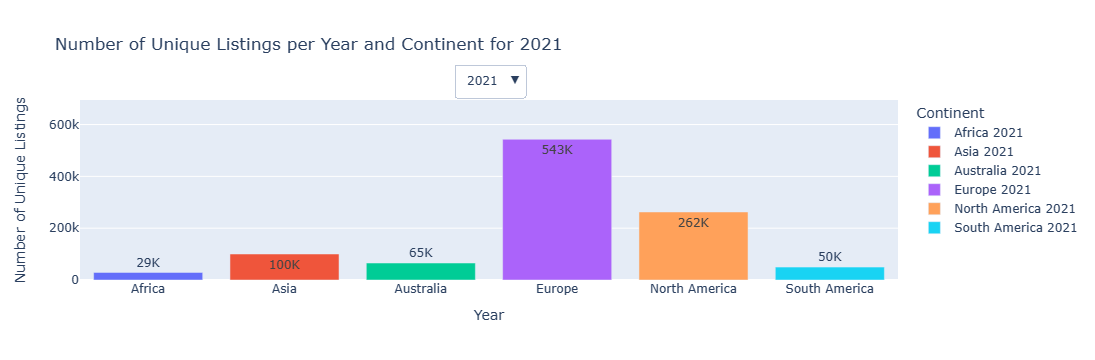

In [42]:
import plotly.graph_objects as go
import pandas as pd

# Group by year and continent, then sum up the unique listings across room types
aggregated_df = (listing_counts_df.groupby(["year", "continent"],
                                          as_index=False)["unique_listings"]
                 .sum())

# Create figure
fig = go.Figure()

# Get unique years and continents
years = sorted(aggregated_df["year"].unique())
continents = aggregated_df["continent"].unique()

# Calculate the maximum number of unique listings to standardize the y-axis range
max_listings = aggregated_df["unique_listings"].max()

# Initialize traces, one trace per year per continent
for year in years:
    for continent in continents:
        filtered_df = aggregated_df[
            ((aggregated_df["continent"] == continent)
             & (aggregated_df["year"] == year))
        ]
        # Round values to the nearest thousand and format for display
        labels = ([f"{round(x / 1000)}K"
                   for x in filtered_df["unique_listings"]])
        fig.add_trace(
            go.Bar(
                x=[continent],
                y=filtered_df["unique_listings"],
                text=labels,
                textposition="auto",  
                name=f"{continent} {year}",
                visible=(
                    year == max(years)
                ),
            )
        )


fig.update_layout(
    barmode="group",
    title="Number of Unique Listings per Year and Continent",
    xaxis_title="Year",
    yaxis_title="Number of Unique Listings",
    legend_title="Continent",
    yaxis=dict(range=[0, max_listings + max_listings * 0.1]),
)


year_buttons = [
    dict(
        label=str(year),
        method="update",
        args=[
            {"visible": [yr == year for yr in years for _ in continents]},
            {"title":
             f"Number of Unique Listings per Year and Continent for {year}"},
        ],
    )
    for year in years
]

# Add dropdown menu to the figure
fig.update_layout(
    updatemenus=[
        dict(x=0.5, y=1.2, xanchor="center",
             yanchor="top", buttons=year_buttons)
    ]
)

# Show the figure
fig.show()

In [43]:
print("Figure 3.")

Figure 3.


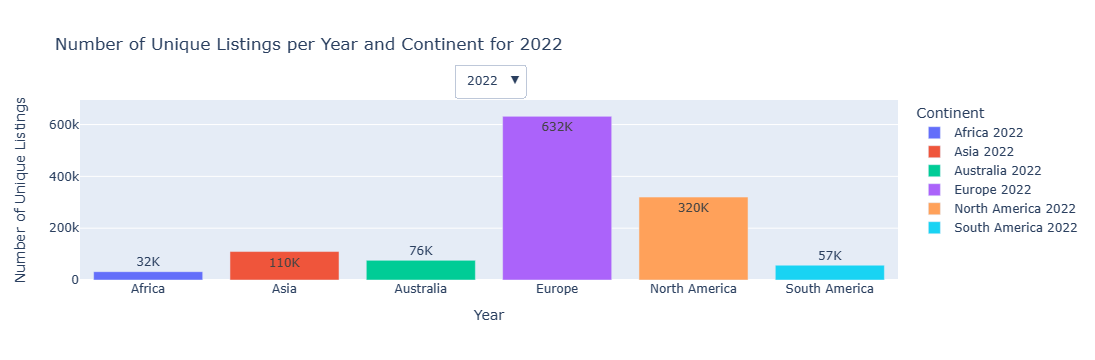

In [44]:
# Group by year and continent, then sum up the unique listings across room types
aggregated_df = (listing_counts_df.groupby(["year", "continent"],
                                          as_index=False)["unique_listings"]
                 .sum())

# Create figure
fig = go.Figure()

# Get unique years and continents
years = sorted(aggregated_df["year"].unique())
continents = aggregated_df["continent"].unique()

# Calculate the maximum number of unique listings to standardize the y-axis range
max_listings = aggregated_df["unique_listings"].max()

# Initialize traces, one trace per year per continent
for year in years:
    for continent in continents:
        filtered_df = aggregated_df[
            ((aggregated_df["continent"] == continent)
             & (aggregated_df["year"] == year))
        ]
        # Round values to the nearest thousand and format for display
        labels = ([f"{round(x / 1000)}K"
                   for x in filtered_df["unique_listings"]])
        fig.add_trace(
            go.Bar(
                x=[continent],
                y=filtered_df["unique_listings"],
                text=labels,
                textposition="auto",  
                name=f"{continent} {year}",
                visible=(
                    year == max(years)
                ),
            )
        )


fig.update_layout(
    barmode="group",
    title="Number of Unique Listings per Year and Continent",
    xaxis_title="Year",
    yaxis_title="Number of Unique Listings",
    legend_title="Continent",
    yaxis=dict(range=[0, max_listings + max_listings * 0.1]),
)


year_buttons = [
    dict(
        label=str(year),
        method="update",
        args=[
            {"visible": [yr == year for yr in years for _ in continents]},
            {"title":
             f"Number of Unique Listings per Year and Continent for {year}"},
        ],
    )
    for year in years
]

# Add dropdown menu to the figure
fig.update_layout(
    updatemenus=[
        dict(x=0.5, y=1.2, xanchor="center",
             yanchor="top", buttons=year_buttons)
    ]
)

# Show the figure
fig.show()

In [45]:
print("Figure 4.")

Figure 4.


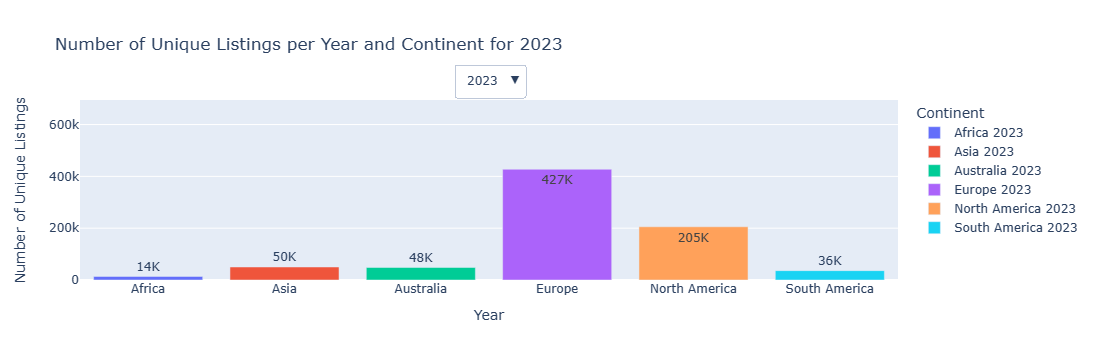

In [47]:
# Group by year and continent, then sum up the unique listings across room types
aggregated_df = (listing_counts_df.groupby(["year", "continent"],
                                          as_index=False)["unique_listings"]
                 .sum())

# Create figure
fig = go.Figure()

# Get unique years and continents
years = sorted(aggregated_df["year"].unique())
continents = aggregated_df["continent"].unique()

# Calculate the maximum number of unique listings to standardize the y-axis range
max_listings = aggregated_df["unique_listings"].max()

# Initialize traces, one trace per year per continent
for year in years:
    for continent in continents:
        filtered_df = aggregated_df[
            ((aggregated_df["continent"] == continent)
             & (aggregated_df["year"] == year))
        ]
        # Round values to the nearest thousand and format for display
        labels = ([f"{round(x / 1000)}K"
                   for x in filtered_df["unique_listings"]])
        fig.add_trace(
            go.Bar(
                x=[continent],
                y=filtered_df["unique_listings"],
                text=labels,
                textposition="auto",  
                name=f"{continent} {year}",
                visible=(
                    year == max(years)
                ),
            )
        )


fig.update_layout(
    barmode="group",
    title="Number of Unique Listings per Year and Continent",
    xaxis_title="Year",
    yaxis_title="Number of Unique Listings",
    legend_title="Continent",
    yaxis=dict(range=[0, max_listings + max_listings * 0.1]),
)


year_buttons = [
    dict(
        label=str(year),
        method="update",
        args=[
            {"visible": [yr == year for yr in years for _ in continents]},
            {"title":
             f"Number of Unique Listings per Year and Continent for {year}"},
        ],
    )
    for year in years
]

# Add dropdown menu to the figure
fig.update_layout(
    updatemenus=[
        dict(x=0.5, y=1.2, xanchor="center",
             yanchor="top", buttons=year_buttons)
    ]
)

# Show the figure
fig.show()

In [48]:
print("Figure 5.")

Figure 5.


<h4 style=" color: #0">Availability Ratio</h4>

The chart depicts the Availability Ratio, which indicates the proportion of listings that are vacant (available) each month. A higher ratio signifies more available properties.

Looking at the data, we see a significant decrease in Asia's (red line) Availability Ratio in mid-2022. This suggests a surge in occupancy, possibly hinting at a tourism recovery in the region. By the end of 2023, Asia's Availability Ratio sits close to North America's, at around 40%.

It's important to note a couple of limitations:

- The reason for the sudden drop in Asia's Availability Ratio in 2022 is unclear. Further analysis of the dataset done so far has not explained this trend.
- The results might not perfectly align with the information mentioned earlier in the Motivation. This could be due to inherent limitations of the data used in this analysis.

In [12]:
availability_df = (
    combined_df.groupby("continent", "year_month")
    .agg(
        F.count("*").alias("total_listings"),
        F.sum(F.when(F.col("available") == "t", 1).otherwise(0)).alias(
            "total_available"
        ),
    )
    .withColumn(
        "availability_ratio",
        (F.col("total_available") / F.col("total_listings"))
    )
    .orderBy("continent", "year_month")
).toPandas()

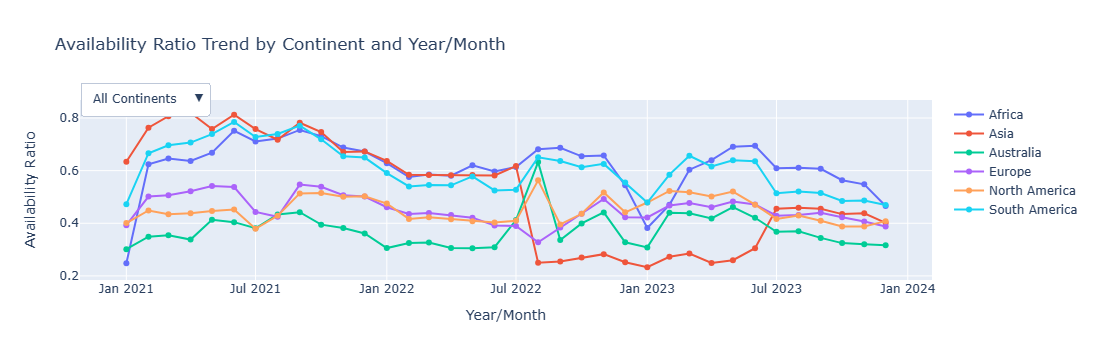

In [13]:
# Create the figure object
fig = go.Figure()

# Unique continents for dropdown menu
continents = availability_df['continent'].unique()

# Adding traces for each continent
for continent in continents:
    df_continent = availability_df[availability_df['continent'] == continent]
    fig.add_trace(go.Scatter(
        x=df_continent['year_month'],
        y=df_continent['availability_ratio'],
        mode='lines+markers',
        name=continent
    ))

# Add dropdowns for continent selection
buttons = []

# Button for all continents
buttons.append(dict(
    method='update',
    label='All Continents',
    args=[{'visible': [True]*len(continents)},  # Set all to True
          {'title': 'Availability Ratio Trend for All Continents'}]
))

for continent in continents:
    buttons.append(dict(
        method='update',
        label=continent,
        args=[{'visible': [continent == cont for cont in continents]},
              {'title': f'Availability Ratio Trend for {continent}'}]))

# Add dropdown menu to the figure
fig.update_layout(
    updatemenus=[
        dict(
            x=0.0,
            y=1.1,
            xanchor='left',
            yanchor='top',
            buttons=buttons
        )
    ],
    title='Availability Ratio Trend by Continent and Year/Month',
    xaxis_title='Year/Month',
    yaxis_title='Availability Ratio'
)

# Show figure
fig.show()


In [14]:
print("Figure 6.")

Figure 6.


<h4 style=" color: #0">Average Price</h4>

This chart showcases the average price per night for properties across different continents. As with the Availability Ratio, Asia's (mentioned irregularity) price trend stands out due to another sharp decline in 2022. 

**We dove deeper into this and saw that there are a lot of outliers (ie. extremely high values) for all countries but somehow only Asia pre-04/2022 was affected.**

In [8]:
price_stats_asia = (
    combined_df.filter(F.col("continent") == "Asia")
    .withColumn("year", F.year(F.to_date("year_month", "yyyy-MM")))
    .withColumn("converted_price",
                convert_to_usd_udf(F.col("country"), F.col("price")))
    .groupby("year")
    .agg(
        F.count("converted_price").alias("count"),
        F.mean("converted_price").alias("mean_price"),
        F.stddev("converted_price").alias("std_dev_price"),
        F.min("converted_price").alias("min_price"),
        F.max("converted_price").alias("max_price"),
        F.expr("percentile_approx(converted_price, 0.25)").alias(
            "25th_percentile"),
        F.expr("percentile_approx(converted_price, 0.5)").alias(
            "50th_percentile"),
        F.expr("percentile_approx(converted_price, 0.75)").alias(
            "75th_percentile"),
    )
).toPandas()

In [61]:
print('Table 12. Summary statistics of prices across Airbnb listings in Asia')

Table 12. Summary statistics of prices across Airbnb listings in Asia


In [9]:
price_stats_asia

year     count   mean_price  std_dev_price  min_price    max_price  \
0  2023  11683358   143.466686     591.419157        0.0     100003.6   
1  2022  24849723   788.716441  302478.983731        0.0  140000000.0   
2  2021  31839113  1609.081545  456145.468464        0.0  140000000.0   

   25th_percentile  50th_percentile  75th_percentile  
0            33.75            57.60           108.92  
1            35.00            57.12           104.02  
2            33.32            55.72            96.46

In [69]:
mean_price_df_year_month = (
    combined_df
    .withColumn('converted_price',
                convert_to_usd_udf(F.col('country'), F.col('price')))
    .groupby('continent', 'year_month')
    .agg(F.mean('converted_price').alias('mean_price'))
    .orderBy('continent', 'year_month')
).toPandas()

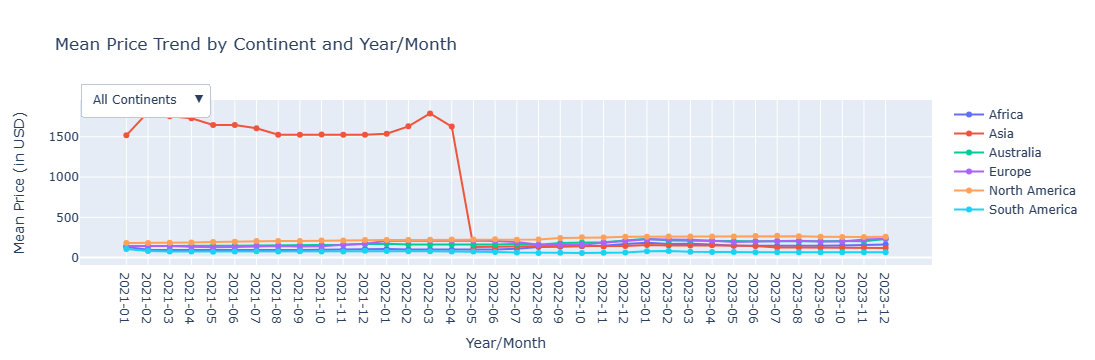

In [29]:
# Create the figure object
fig = go.Figure()

# Unique continents for dropdown menu
continents = mean_price_df_year_month["continent"].unique()

# Adding traces for each continent
for continent in continents:
    df_continent = mean_price_df_year_month[
        mean_price_df_year_month["continent"] == continent
    ]
    fig.add_trace(
        go.Scatter(
            x=df_continent["year_month"],
            y=df_continent["mean_price"],
            mode="lines+markers",
            name=continent,
        )
    )

# Add dropdowns for continent selection
buttons = []

# Button for all continents
buttons.append(
    dict(
        method="update",
        label="All Continents",
        args=[
            {"visible": [True] * len(continents)},
            {"title": "Mean Price Trend for All Continents"},
        ],
    )
)

# Buttons for each continent
for continent in continents:
    buttons.append(
        dict(
            method="update",
            label=continent,
            args=[
                {"visible": [continent == cont for cont in continents]},
                {"title": f"Mean Price Trend for {continent}"},
            ],
        )
    )

# Add dropdown menu to the figure
fig.update_layout(
    updatemenus=[dict(x=0.0, y=1.1, xanchor="left", yanchor="top",
                      buttons=buttons)],
    title="Mean Price Trend by Continent and Year/Month",
    xaxis_title="Year/Month",
    yaxis_title="Mean Price (in USD)",
    xaxis=dict(tickmode="linear", type="category"),
)

# Show figure
fig.show()

In [49]:
print("Figure 7.")

Figure 7.


Since the price seems to follow a similar pattern to other continents after this drop, we've chosen to focus on the data from that point onwards.  This analysis reveals that Asia boasts the second-lowest average property price, only slightly higher than South America by the end of 2023. This presents a compelling opportunity for budget-conscious travelers seeking to explore a new continent.

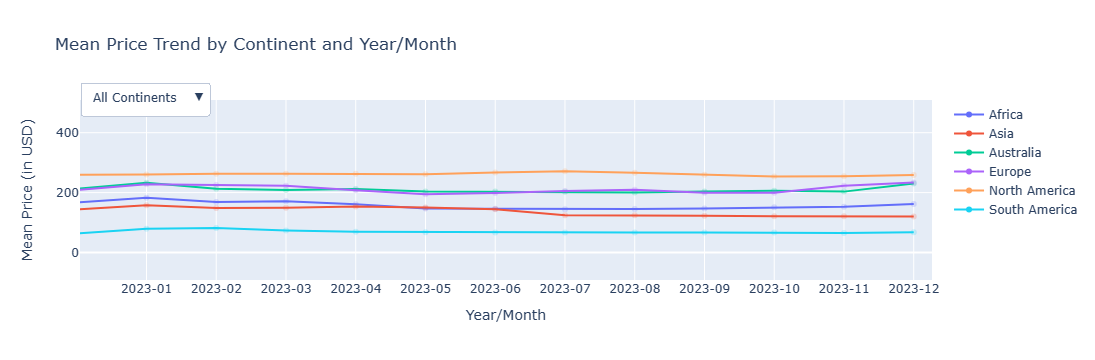

In [60]:
zoomed_mean_price = 'mean_price_plot.png'
Image(filename=zoomed_mean_price)

In [48]:
print("Figure 8.")

Figure 8.


<h3 style=" color: #045a63">Looking Ahead (2024)</h3>

This portion delves into the same metrics explored earlier, focusing specifically on Asian listings for the year 2024. It's important to note that the data covers five major Asian cities: Hong Kong, Tokyo, Bangkok, Taipei, and Singapore.

In [18]:
asia_cal = spark.read.parquet('bdcc_lab/partitioned_calendar_parquet'
                              '/continent=Asia')

In [19]:
asia_df = asia_cal.filter(F.col('year_month')>='2024-01')
list_df = listing_roomtype
combined_df_asia = asia_df.join(list_df,
                          asia_df.listing_id==list_df.id,
                          how='inner')

<h4 style=" color: #0">Listing Types</h4>

Observing below, Bangkok is the most represented Asian city in the dataset followed by Tokyo. Bangkok and Hong Kong show a balanced mix of entire places and private rooms, catering to budget-conscious travelers and diverse visitor types. 

In contrast, Tokyo and Taipei, major tourist hubs, lean towards entire places, likely due to their focus on longer stays and the privacy needs of families and groups.

Singapore stands out with a dominance of entire listings. This makes sense considering the city's limited space and high-density living. Unlike other Asian cities with standalone houses or apartments, Singapore's condo-heavy landscape influences its Airbnb market, with travelers opting for entire apartments within these high-rise buildings.

In [20]:
asia_listing_counts = (
    combined_df_asia
    .groupBy('country', 'city', 'room_type')
    .agg(F.countDistinct('listing_id').alias('unique_listings'))
    .orderBy('country', 'city', 'room_type')
).toPandas()

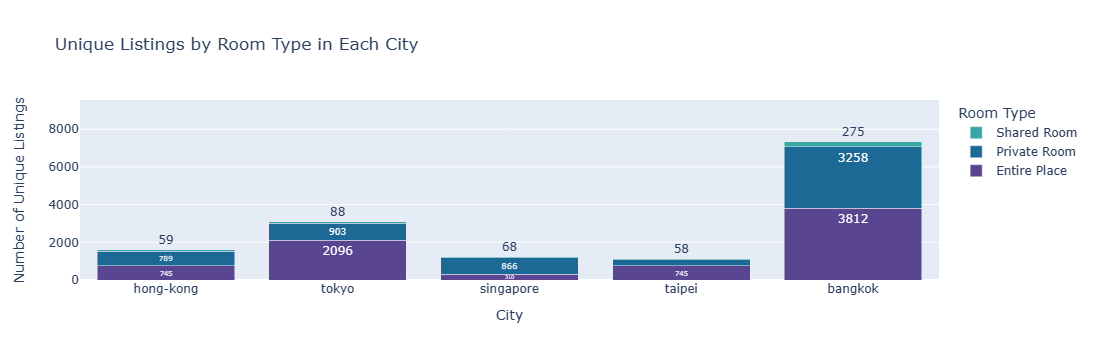

In [21]:
df = asia_listing_counts

agg_df = df.groupby("city")["unique_listings"].sum()
max_y = agg_df.max()
# Create a figure
fig = go.Figure()

# Get unique countries and room types
countries = df["country"].unique()
room_types = df["room_type"].unique()

# Color mapping for room types
color_map = {
    "Entire Place": "rgb(90, 70, 144)",
    "Private Room": "rgb(29, 105, 150)",
    "Shared Room": "rgb(56, 166, 165)",
}

# Track legend addition to avoid duplicates
legend_added = set()

# Loop through each country and each room type
for country in countries:
    filtered_country_df = df[df["country"] == country]
    cities = filtered_country_df["city"].unique()
    for room_type in room_types:
        filtered_room_df = filtered_country_df[
            filtered_country_df["room_type"] == room_type
        ]
        fig.add_trace(
            go.Bar(
                x=filtered_room_df["city"],
                y=filtered_room_df["unique_listings"],
                name=room_type,
                text=filtered_room_df["unique_listings"],
                textposition="auto",
                marker_color=color_map[room_type],  
                showlegend=room_type
                not in legend_added, 
            )
        )
        legend_added.add(room_type) 

# Change the bar mode to stack
fig.update_layout(
    barmode="stack",
    title="Unique Listings by Room Type in Each City",
    xaxis_title="City",
    yaxis_title="Number of Unique Listings",
    legend_title="Room Type",
    yaxis=dict(range=[0, max_y * 1.3]),
)

# Show the figure
fig.show()

In [22]:
print("Figure 9.")

Figure 9.


<h4 style=" color: #0">Availability</h4>

Across Asian cities, availability trends reveal a similar pattern with varying degrees. A clear spike in demand begins in July, peaking from October until January (assuming 2025 exhibit the same trend).

For cities like Singapore, Bangkok, and Hong Kong, the monsoon season's conclusion ushers in pleasant weather, perfect for outdoor activities and festivals. This coincides with the year's end, when many Asian cities host major shopping festivals and sales, further fueled by year-end bonuses for employees. This festive atmosphere likely fuels tourist demand.

On the other hand, cooler winter months in Tokyo and Taipei hold a different appeal. Tourists flock to these cities to experience hot springs, winter sports, and seasonal delicacies. This highlights the diverse seasonal attractions that various Asian destinations offer throughout the year.



In [23]:
asia_availability_df = (
    combined_df_asia.groupby("city", "year_month")
    .agg(
        F.count("*").alias("total_listings"),
        F.sum(F.when(F.col("available") == "t", 1).otherwise(0)).alias(
            "total_available"
        ),
    )
    .withColumn(
        "availability_ratio",
        (F.col("total_available") / F.col("total_listings"))
    )
    .orderBy("city", "year_month")
).toPandas()

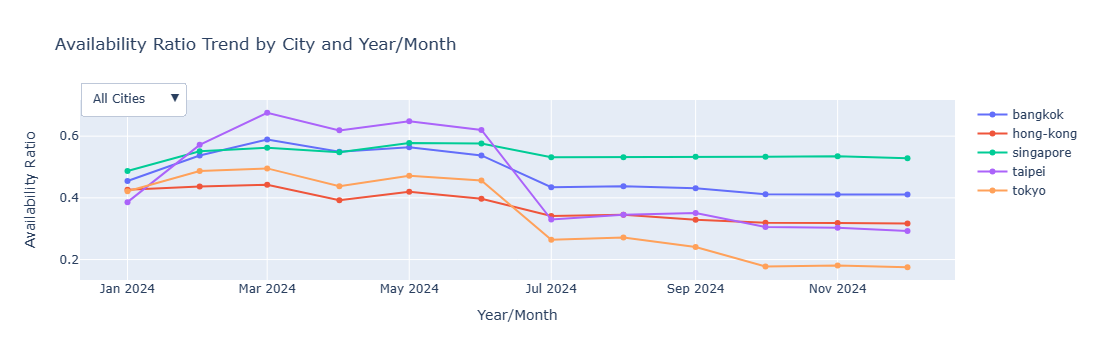

In [24]:
# Create the figure object
fig = go.Figure()

# Unique continents for dropdown menu
cities = asia_availability_df["city"].unique()

# Adding traces for each continent
for city in cities:
    df_city = asia_availability_df[asia_availability_df["city"] == city]
    fig.add_trace(
        go.Scatter(
            x=df_city["year_month"],
            y=df_city["availability_ratio"],
            mode="lines+markers",
            name=city,
        )
    )

# Add dropdowns for continent selection
buttons = []

# Button for all continents
buttons.append(
    dict(
        method="update",
        label="All Cities",
        args=[
            {"visible": [True] * len(cities)},  # Set all to True
            {"title": "Availability Ratio Trend for All Cities in Asia"},
        ],
    )
)

for city in cities:
    buttons.append(
        dict(
            method="update",
            label=city,
            args=[
                {"visible": [city == cit for cit in cities]},
                {"title": f"Availability Ratio Trend for {city}"},
            ],
        )
    )

# Add dropdown menu to the figure
fig.update_layout(
    updatemenus=[dict(x=0.0, y=1.1, xanchor="left", yanchor="top",
                      buttons=buttons)],
    title="Availability Ratio Trend by City and Year/Month",
    xaxis_title="Year/Month",
    yaxis_title="Availability Ratio",
)

# Show figure
fig.show()

In [25]:
print("Figure 10.")

Figure 10.


<h4 style=" color: #0">Price</h4>

Across the five Asian cities, Airbnb prices show surprising stability throughout the year. This suggests consistent pricing strategies despite seasonal tourism shifts.
    
Tokyo boasts the highest prices, likely due to its high cost of living and limited space. Singapore follows closely, influenced by similar factors along with its status as a financial hub. Hong Kong's pricing reflects its dense urban environment and real estate costs.

Bangkok, despite its status as a major tourist destination in Southeast Asia, might have lower prices due to a larger supply of budget-friendly listings and generally lower living costs compared to the other Asian cities analyzed. Taipei offers a more moderate cost of living compared to the likes of Tokyo, Singapore, and Hong Kong which is reflected in its prices.

In [26]:
asia_mean_price_df_year_month = (
    combined_df_asia
    .withColumn('converted_price',
                convert_to_usd_udf(F.col('country'), F.col('price')))
    .groupby('city', 'year_month')
    .agg(F.mean('converted_price').alias('mean_price'))
    .orderBy('city', 'year_month')
).toPandas()

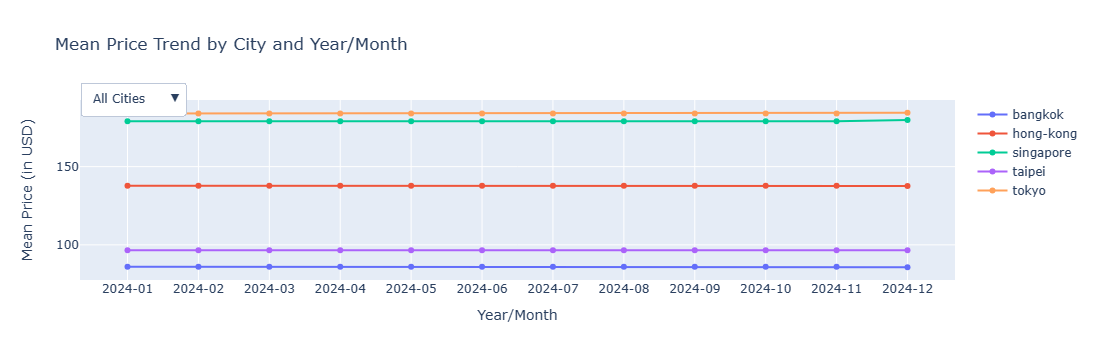

In [27]:
# Create the figure object
fig = go.Figure()

# Unique continents for dropdown menu
cities = asia_mean_price_df_year_month["city"].unique()

# Adding traces for each continent
for city in cities:
    df_cities = asia_mean_price_df_year_month[
        asia_mean_price_df_year_month["city"] == city
    ]
    fig.add_trace(
        go.Scatter(
            x=df_cities["year_month"],
            y=df_cities["mean_price"],
            mode="lines+markers",
            name=city,
        )
    )

# Add dropdowns for continent selection
buttons = []

# Button for all continents
buttons.append(
    dict(
        method="update",
        label="All Cities",
        args=[
            {"visible": [True] * len(cities)},
            {"title": "Mean Price Trend for All Cities"},
        ],
    )
)

# Buttons for each continent
for city in cities:
    buttons.append(
        dict(
            method="update",
            label=city,
            args=[
                {"visible": [city == cit for cit in cities]},
                {"title": f"Mean Price Trend for {city}"},
            ],
        )
    )

# Add dropdown menu to the figure
fig.update_layout(
    updatemenus=[dict(x=0.0, y=1.1, xanchor="left", yanchor="top",
                      buttons=buttons)],
    title="Mean Price Trend by City and Year/Month",
    xaxis_title="Year/Month",
    yaxis_title="Mean Price (in USD)",
    xaxis=dict(tickmode="linear", type="category"),
)

# Show figure
fig.show()

In [28]:
print("Figure 11.")

Figure 11.


<a name="conc"></a>
<h2 style=" color: #045a63">Conclusions and Insights</h2>

***

[ref]: #top
[Back to Table of Contents][ref]


<h3 style=" color: #045a63">Hitchhiker's Guide to Asia</h3>

With the exploratory analysis conclucled, it is time to take these insights to create the Hitchhiker's Guide to Asia.

This guide aims to go over each Asian city covered by the dataset and provide suggestion as to which traveler types are best suited for each destination given its characteristics discovered through research and Big Data analysis.



<h4 style=" color: #0">Hong Kong</h4>

Hong Kong is an excellent choice for short-term business travelers and cultural tourists, offering higher availability from January to June with a similar feel to Singapore and Tokyo at a lower cost.

As a major finance hub, Hong Kong is common destination for corporate visitors. The city boasts a near equal distribution of "Private Room" and "Entire Place" listings, allowing visitors to cater to solo and group travelers alike. 

Cultural tourists can also enjoy famous attractions like Victoria Peak and the bustling street markets in Mong Kok, combining a nice blend of urban and cultural experiences.

                                                                        


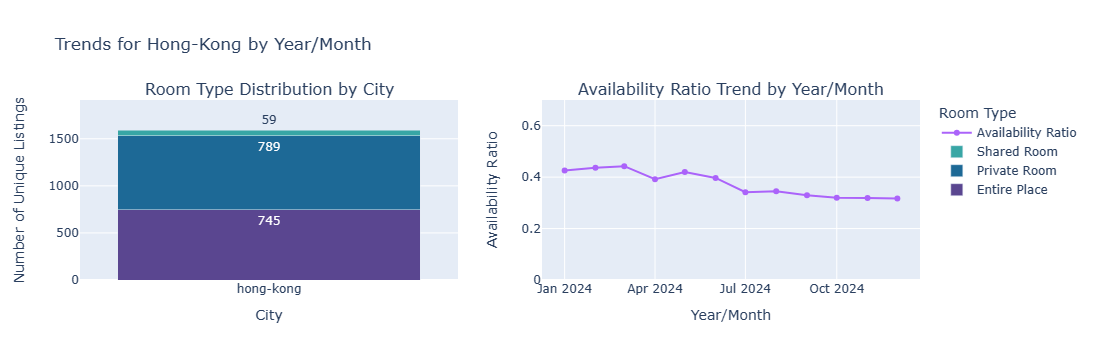

In [53]:
plot_city_trends('hong-kong', asia_listing_counts, asia_availability_df)

In [33]:
print("Figure 12.")

Figure 12.


<h4 style=" color: #0">Tokyo</h4>

Similar to HK, Tokyo is an ideal destination for business travelers, luxury seekers, and cultural tourists, wanting a blend of culture and urban experience. 

The most expensive city on the list, Tokyo justifies its high price tag by providing the highest ratio of "Entire Place" accomodations, putting an emphasis on privacy and luxury. This makes it perfect for groups and families who are looking to spend a bit more on rare vacation. 

The best time to visit being from January to April which would allow tourist to enjoy the city's attractions, like Shibuya Crossing and and the historic Sensō-ji Temple, while avoiding the packed crowds of the peak season.



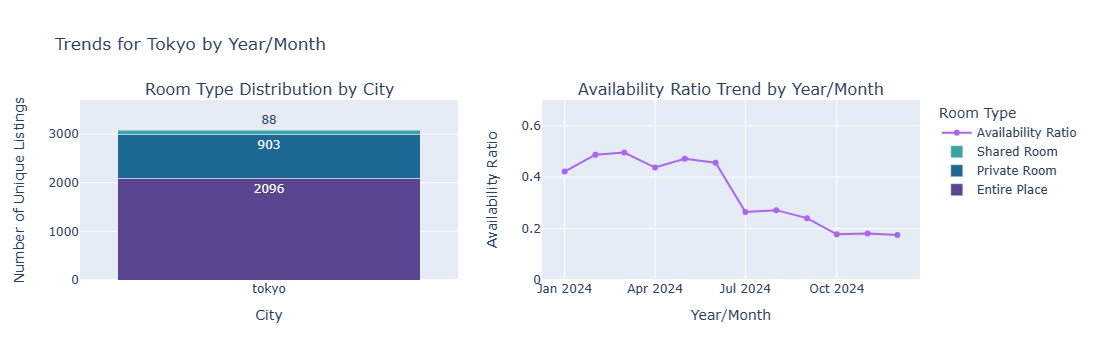

In [54]:
plot_city_trends('tokyo', asia_listing_counts, asia_availability_df)

In [35]:
print("Figure 13.")

Figure 13.


<h4 style=" color: #0">Singapore</h4>

Singapore is a prime location for business visitors and urban explorers. It is advisable to visit the from February to June if the primary goal is to avoid the peak season.

As a hub of modernity and meticulous urban planning, Singapore offers an exceptional environment for exploring iconic urban spaces like Marina Bay Sands and Resorts World Sentosa for those willing to pay. 
    
During these months, travelers expect to find a "Private Room" in on of the cities many condominiums close to the well functioning train system. The country is treat to explore via commute and has a surprising number of museums and cultural sites. 

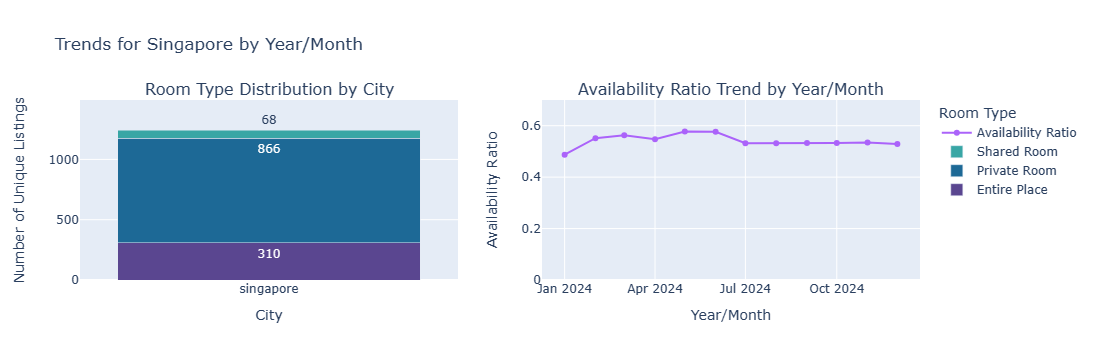

In [55]:
plot_city_trends('singapore', asia_listing_counts, asia_availability_df)

In [37]:
print("Figure 14.")

Figure 14.


<h4 style=" color: #0">Taipei</h4>

Taipei is an attractive destination for food enthusiasts, cultural tourists, and families, with the city being calmest from February through June.

The city is packed with "Entire Place" listings making it particularly suitable for groups and families seeking space and comfort without breaking the bank.
    
The second most affordable city on the list, Taipei offers an inviting blend of culinary delights, vibrant night markets, and grand historic sites like the Chiang Kai-shek Memorial Hall. 



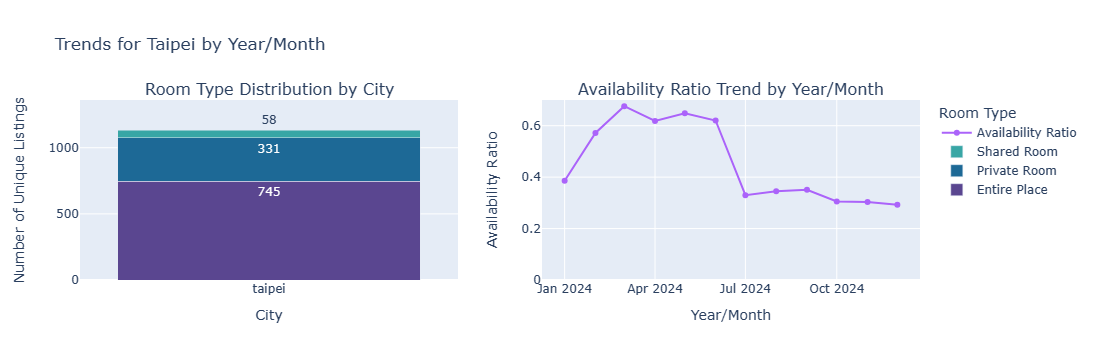

In [56]:
plot_city_trends('taipei', asia_listing_counts, asia_availability_df)

In [39]:
print("Figure 15.")

Figure 15.


<h4 style=" color: #0">Bangkok</h4>

The most affordable city on the list, Bangkok is a top choice for budget travelers, particularly those seeking cultural and adventure tourism. Travel is recommended from February to June to avoid the peak season.

Renowned as a backpacker's haven and a gateway to Southeast Asia, Bangkok provides an extensive cultural experience, featuring landmarks like the Grand Palace, a lively street scene, and a beautiful national sport that captivates visitors. 

The city has a balance of "Entire Place" and "Private Room" listings, providing flexibility to its diverse set of visitors. The city's affordability and location, allow travelers to immerse themselves in Bangkok while saving enough to explore other destinations nearby.


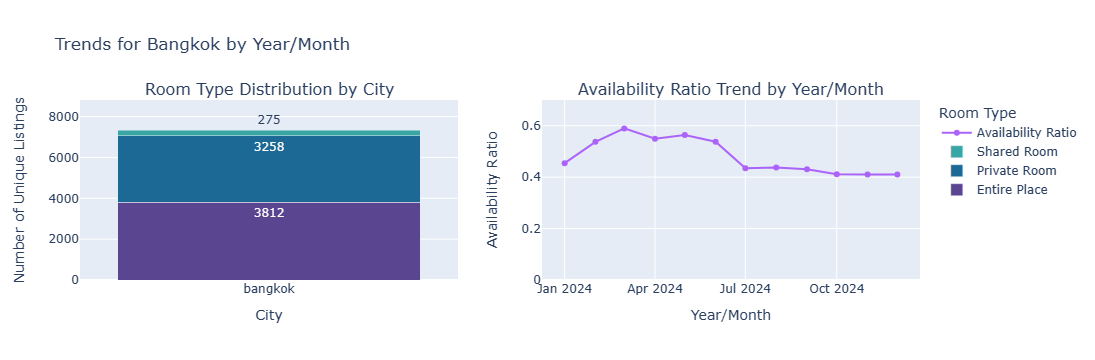

In [57]:
plot_city_trends('bangkok', asia_listing_counts, asia_availability_df)

In [41]:
print("Figure 16.")

Figure 16.


<h3 style=" color: #045a63">Conclusion</h3>

Leveraging Big Data from Airbnb listings, we obtained valuable insights into Asian travel trends. Analysis exposed peak seasons, allowing us to recommend alternative travel times for a less crowded experience. Price analysis revealed surprising stability in average rental costs year-round, enabling affordability rankings. Additionally, room type data provided a perspective on dominant traveler demographics in each city.

These data-driven insights empowered the creation of The Hitchhiker's Guide to Asia, a unique travel guide surpassing traditional blog limitations. Our guide offers personalized city suggestions tailored to specific traveler demographics, going beyond generic recommendations.

Big Data processing presents challenges. As highlighted here, handling massive datasets requires significant time, patience, and navigating computational limitations. Numerous iterations, not detailed here, were necessary to refine the final data pipeline. However, the power of Big Data analytics unlocks the creation of highly informative and data-driven recommendations. 

<a name="reco"></a>
<h2 style=" color: #045a63">Recommendations</h2>

***

[ref]: #top
[Back to Table of Contents][ref]


<h4 style=" color: #0">Data Inputs</h4>

Big Data processing revealed issues with data quality and consistency.  Unique identifiers, ideally numeric, were sometimes strings, requiring extra work to ensure uniqueness and seamless data merging. Price data had zero minimums and extremely large maximums, necessitating investigation into free listings, data errors, or other causes. Finally, the lack of a standard unit for prices (USD, local currency) hindered comparisons.  Addressing these issues through control inputs and secondary checks could help generate and expidite future data analysis.

<h4 style=" color: #0">Expanding Coverage</h4>

To further enhance the comprehensiveness of the travel recommendations, we recommend expanding the dataset's coverage.  Currently, the data may be skewed towards European and North American cities.  Including a wider range of Asian, African, and South American cities would provide a more balanced and globally relevant perspective for travelers.  This expansion would require identifying and incorporating data sources for these under-represented regions.

<h4 style=" color: #0">Future Studies</h4>

The authors also have the following suggestions for future studies wanting to explora the same topic and dataset:

- **Parquet Optimization**: Investigate alternative methods for converting data to Parquet format. There might be more efficient approaches that can accelerate processing speed without compromising data integrity.
- **Feature Enrichment**: Identify and incorporate additional data points relevant to travel recommendations. This could include factors like review scores and min/max night stay to explore other aspects of the data.
- **Price Outlier Analysis**: Delve deeper into price outliers. As observed, price outliers resulted in anomalies in the average price of Asia. However, such outliers were also present in other countries and other dates, but appeared unaffected by its existence. 
This brings us to the conclusion the either removing these outliers through setting up value boundaries or outlier detection would lead to more accurate results. It is also possible that the explanation lies in the documentation history of the data, which explored in brevity during this study.

<a name="refe"></a>
<h2 style=" color: #045a63">References</h2>

***

[ref]: #top
[Back to Table of Contents][ref]

- International Monetary Fund [IMF] (2020). Impact of the pandemic on tourism. https://www.imf.org/-/media/Files/Publications/Fandd/Article/2020/December/impact-of-the-pandemic-on-tourism-behsudi.ashx

- United Nations World Tourism Organization [UNWTO] (2022). World Tourism Barometer. https://www.unwto.org/taxonomy/term/347

<a name="reco"></a>
<h3 style=" color: #045a63">Acknowledgements</h3>

***

OpenAI's ChatGPT and Google's Gemini was used to help proofread markdowns and assist in coding. All ideas, processes and insights are of the authors'.